In [20]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from imageio import imread, imwrite
from scipy.ndimage.filters import convolve
import numba
from tqdm import trange

%matplotlib inline

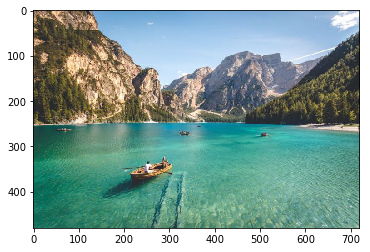

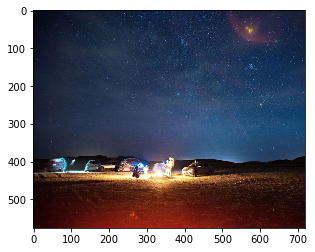

In [21]:
test_du = imread('./test.jpg')
test_dv = imread('./test2.jpg')

plt.imshow(test_du)
plt.show()
plt.imshow(test_dv)
plt.show()

In [22]:
def calc_energy(img):
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])
    # 这会将它从2D滤波转换为3D滤波器
    # 为每个通道：R，G，B复制相同的滤波器
    filter_du = np.stack([filter_du] * 3, axis=2)

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    # 这会将它从2D滤波转换为3D滤波器
    # 为每个通道：R，G，B复制相同的滤波器
    filter_dv = np.stack([filter_dv] * 3, axis=2)

    img = img.astype('float32')
    convolved = np.absolute(convolve(img, filter_du)) + np.absolute(convolve(img, filter_dv))

    # 我们将红，绿，蓝通道中的能量相加
    energy_map = convolved.sum(axis=2)
    
    return energy_map

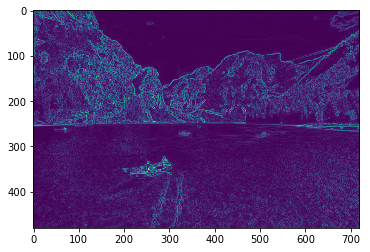

In [23]:
energy_map = calc_energy(test_du)
plt.imshow(energy_map)
plt.show()

In [24]:
@numba.jit
def minimum_seam(img):
    r, c, _ = img.shape
    energy_map = calc_energy(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=np.int)

    for i in range(1, r):
        for j in range(0, c):
            # 处理图像的左侧边缘，确保我们不会索引-1
            if j == 0:
                idx = np.argmin(M[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i - 1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack

In [25]:
@numba.jit
def carve_column(img):
    r, c, _ = img.shape

    M, backtrack = minimum_seam(img)

    # 创建一个(r,c)矩阵，填充值为True
    # 后面会从值为False的图像中移除所有像素
    mask = np.ones((r, c), dtype=np.bool)

    # 找到M的最后一行中的最小元素的位置 
    j = np.argmin(M[-1])

    for i in reversed(range(r)):
        # 标记出需要删除的像素
        mask[i, j] = False
        j = backtrack[i, j]

    # 因为图像有3个通道，我们将蒙版转换为3D
    mask = np.stack([mask] * 3, axis=2)

    # 删除蒙版中所有标记为False的像素，
    # 将其大小重新调整为新图像的维度
    img = img[mask].reshape((r, c - 1, 3))

    return img

In [26]:
def crop_c(img, scale_c):
    r, c, _ = img.shape
    new_c = int(scale_c * c)

    for i in trange(c - new_c): # use range if you don't want to use tqdm
        img = carve_column(img)

    return img


 23%|█████████████▎                                           | 84/360 [00:20<00:51,  5.35it/s]


 47%|██████████████████████████▎                             | 169/360 [00:35<00:35,  5.43it/s]


 71%|███████████████████████████████████████▌                | 254/360 [00:47<00:14,  7.41it/s]


 98%|███████████████████████████████████████████████████████ | 354/360 [00:58<00:00, 10.59it/s]


100%|████████████████████████████████████████████████████████| 360/360 [00:59<00:00, 11.01it/s]

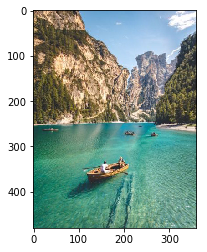

In [27]:
scale = 0.5

out = crop_c(test_du, scale)

plt.imshow(out)